**Differentially private support vector machines (SVM) for binary classification** 

This tutorial details the private computation of a monotone regression model, based on the theory and results of the following preprint:

[Privacy-Preserving Convex Optimization: When Differential Privacy Meets Stochastic Programming]() (2022) by Vladimir Dvorkin, Ferdinando Fioretto, Pascal Van Hentenryck, Pierre Pinson and Jalal Kazempour. 

***

In [1]:
# activate project environment
using Pkg
Pkg.activate()

# load packages 
using JuMP, Ipopt, Mosek, MosekTools
using Distributions, Random
using LinearAlgebra, Plots
using DataFrames

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


Consider a dataset $(x_{1},y_{1}),\dots,(x_{m},y_{m})$ of $m$ data points, where $x_{i}\in\mathbb{R}^{n}$ is a vector of features and $y_{i}\in\{-1,1\}$ is an associated binary label (class). The SVM goal is to compute the maximum-margin hyperplane that separates data points from different classes so as to maximize the distance between the hyperplane and the nearest point. Formally, SVM optimizes hyperplane $w^{\top}x_{i}-b$ with parameters $w\in\mathbb{R}^{n}$ and $b\in\mathbb{R}$, so that any data point $\tilde{x}$ is classified according to the rule $$\text{sign}[w^{\star\top}\tilde{x}-b^{\star}],$$ i.e., depending on which side of the hyperplane the point falls. The optimal hyperplane parameters $w^{\star}$ and $b^{\star}$ are from the solution of the following convex (quadratic) optimization program}:

\begin{align*}
    \underset{b,w,z}{\text{minimize}}\quad&\lambda\lVert{w}\rVert^{2} + \textstyle\frac{1}{m}\mathbb{1}^{\top}z\\
    \text{subject to}\quad&y_{i}(w^{\top}x_{i}-b)\geqslant1-z_{i},\quad z_{i}\geqslant0,\quad\forall i=1,\dots,m,
\end{align*}

with regularization parameter $\lambda$ and slack variable $z\in\mathbb{R}^{m}$ to ensure feasibility when the data points are not fully separable by the hyperplane. Notably, the normal vector $w^{\star}$ of the hyperplane is unique on a particular dataset, and releasing the classification rule leads to privacy breaches. 

Application of the standard mechanisms of  differential privacy, i.e., the output perturbation of the optimal hyperplane parameters or the input perturbation of classification data, is agnostic to SVM objective or constraint. The program perturbation, instead, perturbs the SVM model anticipating the impact of the noise on the loss function value and SVM constraint satisfaction. In particular, it requires solving the following  chance-constrained optimization:

\begin{align*}
    \underset{\overline{b},\overline{w},\overline{z},B,W,Z}{\text{maximize}}\quad&\mathbb{E}\left[\lambda\lVert{\overline{w}+W{\zeta}\rVert}^{2} + \textstyle\frac{1}{m}\mathbb{1}^{\top}(\overline{z}+Z{\zeta})\right]\\
    \text{subject to}\quad&\text{Pr}\left[
    \begin{array}{l}
    y_{i}((\overline{w}+W{\zeta})^{\top}x_{i}-(\overline{b}+B{\zeta}))\geqslant1-\overline{z}_{i}-Z_{i}^{\top}{\zeta},\\
    \overline{z}_{i}-Z_{i}^{\top}{\zeta}\geqslant0,\quad\forall i=1,\dots,m,
    \end{array}
    \right]\geqslant 1-\eta,
    \quad 
    \begin{bmatrix}
    W \\
    B
    \end{bmatrix} = I,
\end{align*}

which minimizes the expected objective function value subject to a chance constraint on perturbed SVM constraints, where linear decision rules are enforced for each decision variable. Additionally, recourse decisions $B$ and $W$ must respect the identity query constraints. Once the chance-constrained program is solved to optimality, the differently private hyperplane release includes free term $\overline{b}^{\star} + B^{\star}\hat{\zeta}$ and normal vector $\overline{w}^{\star} + W^{\star}\hat{\zeta}$, where $\hat{\zeta}$ is a random realization of ${\zeta}$.

***

We generate a classification dataset with 100 training data points from distribution
$\mathcal{N}(
\begin{bmatrix}
1\\1
\end{bmatrix},
\begin{bmatrix}
0.5 & 0.0\\ 0.0 & 0.5
\end{bmatrix})$ for class $y=1$ and distribution
$\mathcal{N}(
\begin{bmatrix}
3\\3
\end{bmatrix},
\begin{bmatrix}
0.5 & 0.0\\ 0.0 & 0.5
\end{bmatrix})$
for class $y=-1$ in equal proportion, and then normalized them using the min-max normalization. 

In [2]:
function load_data(set)

    y = [i <= set[:n]/2 ? -1 : 1 for i in 1:set[:n]]

    # training data
    Random.seed!(25)
    x = [[i <= set[:n]/2 ? set[:x][1] + rand(Normal(0,set[:σ])) : set[:x][2] + rand(Normal(0,set[:σ])) for i in 1:set[:n]] [i <= set[:n]/2 ? set[:y][1] + rand(Normal(0,set[:σ])) : set[:y][2] + rand(Normal(0,set[:σ])) for i in 1:set[:n]]]

    x_min = minimum(x); x_max = maximum(x);
    x_ = (x .- x_min)./(x_max - x_min)

    # test data
    Random.seed!(2)
    x = [[i <= set[:n_test]/2 ? set[:x][1] + rand(Normal(0,set[:σ])) : set[:x][2] + rand(Normal(0,set[:σ])) for i in 1:set[:n_test]] [i <= set[:n_test]/2 ? set[:y][1] + rand(Normal(0,set[:σ])) : set[:y][2] + rand(Normal(0,set[:σ])) for i in 1:set[:n_test]]]

    x_min = minimum(x); x_max = maximum(x);
    x__ = (x .- x_min)./(x_max - x_min)

    y__ = [i <= set[:n_test]/2 ? -1 : 1 for i in 1:set[:n_test]]

    return Dict(:y_train => y, :x_train => x_, :x_test => x__, :y_test => y__)
end


set = Dict( :x => [1 3], :y => [1 3], :σ => 0.5, :n => 100, :n_test => 1000,                # dataset parameters
            :λ => 1e-5,                                                                     # regularization term 
            :K => 100, :d_scale => 0.05,                                                    # scale parameter of dataset universe
            :ccol => cgrad([RGB(240/255,128/255,128/255), RGB(32/255,178/255,170/255)]),
            :mcol => cgrad([RGB(205/255,92/255,92/255), RGB(60/255,179/255,113/255)]))

data = load_data(set)

Dict{Symbol, Array} with 4 entries:
  :x_train => [0.480768 0.288204; 0.280367 0.197196; … ; 0.896697 0.775563; 0.7…
  :y_test  => [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1  …  1, 1, 1, 1, 1, 1, 1, …
  :x_test  => [0.38749 0.280727; 0.253727 0.310435; … ; 0.695515 0.728649; 0.63…
  :y_train => [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1  …  1, 1, 1, 1, 1, 1, 1, …

We first solve the deterministic, non-private SVM model and report its accuracy

In [3]:
function svm_det(set,data)
    m, n = size(data[:x_train])

    model = Model(optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0))

    @variable(model, b)
    @variable(model, w[1:n])
    @variable(model, ζ[1:m] >= 0)

    @objective(model, Min, set[:λ] * w'w + 1/m * sum(ζ[i] for i in 1:m))

    @constraint(model, con[i=1:m], data[:y_train][i]*(w'data[:x_train][i,:] - b) >= 1 - ζ[i])

    optimize!(model)
    marg_ind = [abs(data[:y_train][i]*(JuMP.value.(w)'data[:x_train][i,:] - JuMP.value.(b)) - 1) for i in 1:set[:n]]

    return Dict(:b => JuMP.value.(b), :w => JuMP.value.(w),
                :marg_ind => findall(x -> x <= 1e-2, marg_ind)[1], :obj => JuMP.objective_value(model))
end

function accuracy(w,b,data)
    m, n = size(data[:x_test])
    acc = [sign(w'*data[:x_test][i,:] - b) == sign(data[:y_test][i]) ? 1 : 0 for i in 1:m]
    return acc = sum(acc)/m
end

# solve deterministic SVM
sol = svm_det(set,data)
display(sol)
@show accuracy(sol[:w],sol[:b],data)

Dict{Symbol, Any} with 4 entries:
  :b        => 9.99465
  :w        => [13.4881, 5.59134]
  :marg_ind => 32
  :obj      => 0.00213193

accuracy(sol[:w], sol[:b], data) = 0.992


0.992

The privacy goal here is to make the training dataset indistinguishable from any adjacent dataset when releasing hyperplane parameters. We assume such a dataset universe $\mathbb{D}$, where $i^{\text{th}}$ training data point realizes according to the law $(r\sin(t) + x_{1i}, r\cos(t) + x_{2i}),$ with $r\sim U(0,0.05)$ and $t\sim U(0,2\pi)$, i.e., from the scaled circle area centered at $(x_{1i},x_{2i})$, and we let all training datasets from this universe to be adjacent. 

The the hyperplane parameters are sensitive to datasets from the universe, as shown in the following illustration  

┌ Info: Saved animation to 
│   fn = /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_support_vector_machines/anim_svm.gif
└ @ Plots /Users/vladimirdvorkin/.julia/packages/Plots/Xv2qA/src/animation.jl:114


Plots.AnimatedGif("/Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_support_vector_machines/anim_svm.gif")
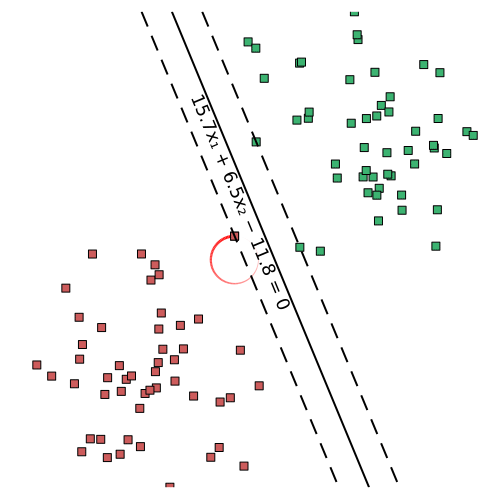

In [4]:
k = 100
t = range(0, 2π, length = k)
x = 0.05*sin.(t) .+ data[:x_train][sol[:marg_ind],:][1]
y = 0.05*cos.(t) .+ data[:x_train][sol[:marg_ind],:][2]

ind = sol[:marg_ind]

@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 3, length = n)
    seriescolor --> :red
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    legend --> false
    x[inds], y[inds]
end


anim = @animate for i ∈ 1:k
    plo = plot(ylim = (0,1), xlim = (0,1), size = (500, 500))
    plot!(frame = nothing, border=:none, axis = nothing, ticks=nothing)


    data[:x_train][ind,:] = [x[i] y[i]]
    sol = svm_det(set,data)
    ŷ(x_,y_) = sign(sol[:w]'*[x_;y_] - sol[:b])
    circleplot!(x, y, i,ylim=(0,1),xlim=(0,1))
    plot!([x[i]],[y[i]], m=:rect , c=set[:mcol][1])

    # plot data points
    scatter!(data[:x_train][1:Int(set[:n]/2),1], data[:x_train][1:Int(set[:n]/2),2], data[:y_train], m=:rect , c=set[:mcol][1], label=false)
    scatter!(data[:x_train][Int(set[:n]/2)+1:end,1], data[:x_train][Int(set[:n]/2)+1:end,2], data[:y_train], m=:rect , c=set[:mcol][2], label=false)

    # plot hyperplanes
    range_x = minimum(data[:x_train]):0.01:maximum(data[:x_train])
    y_hyper = (-sol[:w][1] * range_x .+ sol[:b])/sol[:w][2];
    plot!(range_x, y_hyper, lw = 2, color=:black, label=false)

    x1 = 0.5; x2 = 1
    y1 = (-sol[:w][1] * x1 .+ sol[:b])/sol[:w][2]
    y2 = (-sol[:w][1] * x2 .+ sol[:b])/sol[:w][2]
    dx = x2 - x1
    dy = y2 - y1
    # annotate!([(x1,y1,text("x₂ = $(-round(sol[:w][1]/sol[:w][2],digits=3))x₁ + $(round(sol[:b]/sol[:w][2],digits=3))", 10, :top, :white,rotation = (atan(dy/dx))*180/pi))])
    # annotate!([(x1,y1,text("$(round(sol[:w][1],digits=1))x₁ + $(round(sol[:w][2],digits=1))x₂ − $(round(sol[:b],digits=1))=0", 12, :top, :white,rotation = (atan(dy/dx))*180/pi))])
    annotate!([(x1,y1,text("$(round(sol[:w][1],digits=1))x₁ + $(round(sol[:w][2],digits=1))x₂ − $(round(sol[:b],digits=1)) = 0", 12, :top, :black,rotation = (atan(dy/dx))*180/pi))])

    plot!(range_x, y_hyper .+ 1/sol[:w][2], lw = 2, color=:black, linestyle=:dash, label=false)
    plot!(range_x, y_hyper .- 1/sol[:w][2], lw = 2, color=:black, linestyle=:dash, label=false)

end
gif(anim, "anim_svm.gif", fps = 24)


We assess the sensitivity $\Delta_{p}$ of hyperplane parameters to adjacent datasets using Algorithm 1 with adjacency parameter $\alpha=\infty$, norm order $p=1$, and sample size requirement $S=99$ (for $\gamma=\beta=0.1$ of Proposition 3.2.

In [5]:
function sampled_sensitivity(data,set)
    res = zeros(3,2,set[:K])
    Δ = zeros(set[:K])
    for i in 1:set[:K]
        # first run
        data_ = copy(data)
        ξ = [set[:d_scale] .* rand(Uniform(0,1),set[:n]) .* sin.(rand(Uniform(0,2*π),set[:n])) set[:d_scale] .* rand(Uniform(0,1),set[:n]) .* cos.(rand(Uniform(0,2*π),set[:n]))]
        data_[:x_train] = data_[:x_train] .+ ξ
        sol = svm_det(set,data_)
        res[1:2,1,i] = sol[:w] ; res[3,1,i] = sol[:b]
        # second run
        data_ = copy(data)
        ξ = [set[:d_scale] .* rand(Uniform(0,1),set[:n]) .* sin.(rand(Uniform(0,2*π),set[:n])) set[:d_scale] .* rand(Uniform(0,1),set[:n]) .* cos.(rand(Uniform(0,2*π),set[:n]))]
        data_[:x_train] = data_[:x_train] .+ ξ
        sol = svm_det(set,data_)
        res[1:2,2,i] = sol[:w] ; res[3,2,i] = sol[:b]

        Δ[i] = norm(res[:,1,i] .- res[:,2,i],1)
    end
    return maximum(Δ)
end

Random.seed!(2)
set_privacy = Dict(:Δ_output => NaN, :Δ_input => NaN, :ε => 1, :α => 1)
set_privacy[:Δ_output] = sampled_sensitivity(data,set)

41.42712640153677

To provide a pure $1$-differential privacy ($\varepsilon=1$) to training datasets, we use Laplace perturbation ${\zeta}\sim\text{Lap}(1/21.8)$ and first deploy the output perturbation strategy, i.e., by directly perturbing the deterministic solution. 

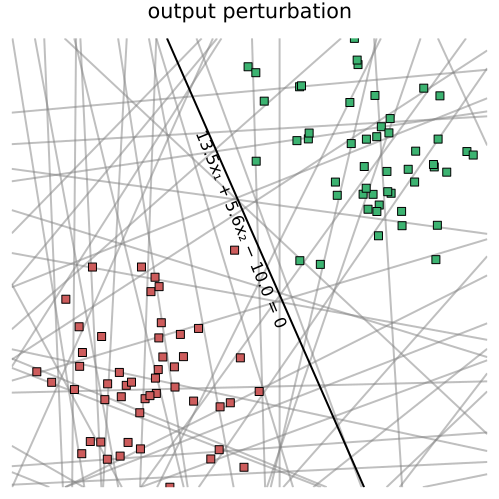

(mean([accuracy((sol_op[:w̃])[:, i], (sol_op[:b̃])[i], data) for i = 1:set[:K]]), std([accuracy((sol_op[:w̃])[:, i], (sol_op[:b̃])[i], data) for i = 1:set[:K]])) = (0.5387299999999999, 0.15209120436252863)


(0.5387299999999999, 0.15209120436252863)

In [8]:
function plot_perturbation(data,solution,title_)

    plo = plot(legend=false, ylim =(0,1), xlim =(0,1), size = (500, 500))

    ŷ(x_,y_) = sign(solution[:w]'*[x_;y_] - solution[:b])
    # contour!(minimum(data[:x_train]):0.005:maximum(data[:x_train]), minimum(data[:x_train]):0.005:maximum(data[:x_train]), ŷ, f=true, nlev=2, c=set[:ccol])
    plot!(legend=false, frame = nothing, border=:none, axis = nothing, ticks=nothing)
    for i in 1:set[:K]
        f(x) = -solution[:w̃][1,i]/solution[:w̃][2,i]*x + solution[:b̃][i]/solution[:w̃][2,i]
        plot!(f,0,100,c=:gray, lw=2, alpha=0.5, label=false)
    end

    scatter!(data[:x_train][1:Int(set[:n]/2),1], data[:x_train][1:Int(set[:n]/2),2], data[:y_train], m=:rect , c=set[:mcol][1], label="y=1")
    scatter!(data[:x_train][Int(set[:n]/2)+1:end,1], data[:x_train][Int(set[:n]/2)+1:end,2], data[:y_train], m=:rect , c=set[:mcol][2], label="y=−1")

    # plot the base hyperplane
    range_x = minimum(data[:x_train]):0.01:maximum(data[:x_train])
    y_hyper = (-solution[:w][1] * range_x .+ solution[:b])/solution[:w][2];
    plot!(range_x, y_hyper, lw = 2, color=:black, label=false)
    x1 = 0.5; x2 = 1
    y1 = (-solution[:w][1] * x1 .+ solution[:b])/solution[:w][2]
    y2 = (-solution[:w][1] * x2 .+ solution[:b])/solution[:w][2]
    dx = x2 - x1
    dy = y2 - y1
    annotate!([(x1,y1,text("$(round(solution[:w][1],digits=1))x₁ + $(round(solution[:w][2],digits=1))x₂ − $(round(solution[:b],digits=1)) = 0", 11, :top, :black,rotation = (atan(dy/dx))*180/pi))])

    plot!(title=title_)
    plot!(xtickfont=font(10))
    plot!(ytickfont=font(10))
    plot!(legendfontsize=6)
    plot!(xlabelfontsize=10)
    return plo
end

# plot output perturbation results
ξ = rand(Laplace(0,(set_privacy[:Δ_output]/set_privacy[:ε])),set[:K],3)
sol_op = Dict(:w̃ => sol[:w] .+ ξ[:,1:2]', :b̃ => sol[:b] .+ ξ[:,3], :w => sol[:w], :b => sol[:b])
plot_out = plot_perturbation(data,sol_op,"output perturbation")
display(plot_out)
@show mean([accuracy(sol_op[:w̃][:,i],sol_op[:b̃][i],data) for i in 1:set[:K]]), std([accuracy(sol_op[:w̃][:,i],sol_op[:b̃][i],data) for i in 1:set[:K]])



The plot displays 100 random hyperplanes (in gray) resulting from the output perturbation. The resulting class separations are of poor quality with low mean classification accuracy and high standard deviation on the testing dataset. 

Next, we deploy the proposed program perturbation strategy by perturbing the nominal solution of chance-constrained program with the same Laplace noise as in output perturbation while requiring solution feasibility with a probability at least $1-\eta=95\%$. 




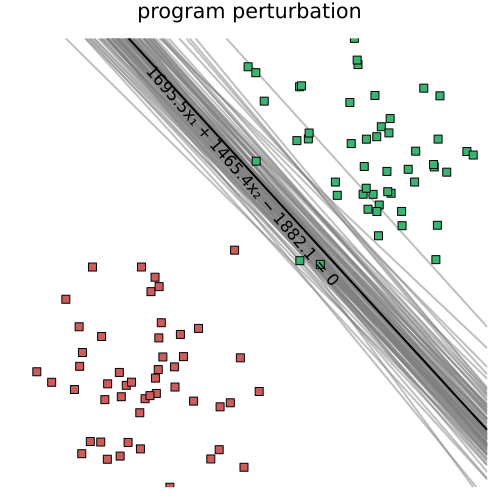

┌ Info: det regression status : OPTIMAL
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_support_vector_machines/PrivateSVM.ipynb:22


(mean([accuracy((sol_sto[:w̃])[:, i], (sol_sto[:b̃])[i], data) for i = 1:set[:K]]), std([accuracy((sol_sto[:w̃])[:, i], (sol_sto[:b̃])[i], data) for i = 1:set[:K]])) = (0.9524300000000001, 0.04262504006337167)


(0.9524300000000001, 0.04262504006337167)

In [9]:
Φ(x) = sqrt((1-x)/x) 

function svm_sto(set,data,set_cc)
    k = size(set_cc[:Σ],1)
    m, n = size(data[:x_train])

    model = Model(optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0))
    # , "print_level" => 0))
    @variable(model, b̅)
    @variable(model, B[1,1:k])
    @variable(model, z[1:m])
    @variable(model, w̅[1:n])
    @variable(model, W[1:n,1:k])

    @objective(model, Min, set[:λ] * w̅'w̅ + set[:λ] * tr(W*set_cc[:Σ]*W') + 1/m * sum(z[i] for i in 1:m))

    @constraint(model, con[i=1:m], [data[:y_train][i]*(w̅' * data[:x_train][i,:] - b̅ + z[i]) - 1 ; Φ(set_cc[:η]) *(cholesky(set_cc[:Σ]).L .+ 1e-6) * vec(data[:y_train][i] .* data[:x_train][i,:]' * W .- B)] in SecondOrderCone())
    @constraint(model, [W;B] .== diagm(ones(k)))
    @constraint(model, z .>= 0)

    optimize!(model)
    @info("det regression status : $(termination_status(model))")

    JuMP.value.(w̅)
    JuMP.value.(b̅)
    return Dict(:w̅ => JuMP.value.(w̅), :b̅ => JuMP.value.(b̅), :W => JuMP.value.(W), :B => JuMP.value.(B), :obj => JuMP.objective_value(model))
end

# program perturbation
set_cc = Dict(:Σ => diagm(ones(3)*2*(set_privacy[:Δ_output]/set_privacy[:ε])^2), :η => 0.05)
sol_ = svm_sto(set,data,set_cc)
ξ = rand(Laplace(0,(set_privacy[:Δ_output]/set_privacy[:ε])),set[:K],3)
sol_sto = Dict(:w̃ => sol_[:w̅] .+ ξ[:,1:2]', :b̃ => sol_[:b̅] .+ ξ[:,3], :w => sol_[:w̅], :b => sol_[:b̅])
plot_pro = plot_perturbation(data,sol_sto,"program perturbation")
display(plot_pro)
@show mean([accuracy(sol_sto[:w̃][:,i],sol_sto[:b̃][i],data) for i in 1:set[:K]]), std([accuracy(sol_sto[:w̃][:,i],sol_sto[:b̃][i],data) for i in 1:set[:K]])

The plot displays 100 random hyperplanes resulting from the program perturbation. Observe, that the nominal hyperplane parameters exceed those of the deterministic solution by 2 orders of magnitude. Thus, the hyperplane becomes less sensitive to perturbation, which results in a more stable distribution of the random hyperplanes around the nominal solution. The strategy demonstrates a significantly higher classification accuracy on average with much smaller standard deviation on the testing dataset. Hence, the desired privacy protection of the training dataset is achieved while maintaining the classification accuracy closer to that of the deterministic, non-private solution. 